In [1]:
__author__ = 'racah'
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from nbfinder import NotebookFinder
import sys
import os
sys.meta_path.append(NotebookFinder())
%matplotlib inline

In [2]:
def load_data(path='/global/project/projectdirs/das/wbhimji/RPVSusyJetLearn/',
              bg_file='jj_DAOD_EXOT3.h5',
              sig_file='DAOD_EXOT3.08548071._000001.pool.root.1.h5',
              group_name='caloclusters',
              num_events=30,
              preprocess=True,
              dataset_name='histo'):

    bg_path = os.path.join(path, bg_file)
    sig_path = os.path.join(path, sig_file)

    bgdf = pd.read_hdf(bg_path, group_name)
    sigdf = pd.read_hdf(sig_path, group_name)

    assert num_events % 2 == 0, "why an odd number for num_events?!, even please"
    num_each = num_events / 2


    x_bg = bgdf[dataset_name][:num_each]


    x_sig = sigdf[dataset_name][:num_each]

    #background first
    x_concat = np.hstack((x_bg, x_sig))

    dim_x, dim_y = x_bg[0].shape

    x = np.zeros((num_events ,dim_x, dim_y ))

    for i in range(num_events):
        x[i] = x_concat[i]

    # add a channel size of 1 as a place holder
    x = np.expand_dims(x,axis=1)
    # 1 means signal, 0 means background
    y = np.zeros((num_events,)).astype('int32')
    #make the last half signal label
    y[num_each:] = 1


    #shuffle examples
    rng = np.random.RandomState(seed=9)

    inds = np.arange(num_events)

    rng.shuffle(inds)

    #split train, val, test
    tr_inds = inds[:int(0.6*num_events)] 
    val_inds = inds[int(0.6*num_events):int(0.8*num_events)]
    te_inds = inds[int(0.8*num_events):]
    
    x_tr, y_tr, x_val, y_val, x_te, y_te = x[tr_inds], y[tr_inds], \
                                           x[val_inds], y[val_inds], \
                                           x[te_inds], y[te_inds]
    if preprocess:
        '''a type of sparse preprocessing, which scales everything between -1 and 1 without losing sparsity'''
        #only calculate the statistic using training set
        max_abs=np.abs(x_tr).max(axis=(0,1,2))
        
        #then scale all sets
        x_tr /= max_abs
        x_te /= max_abs
        x_val /= max_abs
    
        
 
    
    return x_tr, y_tr, x_val, y_val, x_te, y_te
    

Opening /global/project/projectdirs/das/wbhimji/RPVSusyJetLearn/jj_DAOD_EXOT3.h5 in read-only mode
Opening /global/project/projectdirs/das/wbhimji/RPVSusyJetLearn/DAOD_EXOT3.08548071._000001.pool.root.1.h5 in read-only mode


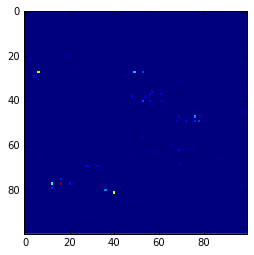

In [16]:
if __name__ == "__main__":
    data = load_data()

    x,y,xv,yv,x_te,y_te = data

    plt.imshow(x[6], interpolation='none')



In [3]:
a = np.random.random((30,100,100))

In [7]:
b=np.expand_dims(a,axis=1)

In [8]:
b.shape

(30, 1, 100, 100)